## Accelegrad vs UnixGrad Analysis 

#### Import Libraries 

In [616]:
import os
import sys
import numpy as np
from scipy import sparse 
import pandas as pd
from random import randrange
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.utils import shuffle
from tqdm.notebook import tqdm


module_path = os.path.abspath(os.path.join('../'))
if module_path not in sys.path:
    sys.path.append(module_path)
print("Main Directory: ", module_path)


from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

Main Directory:  /Users/marcellobullo/Desktop/optimization/Optimization


In [617]:
def load_data( path ):

    # import
    data = pd.read_csv( path, delimiter=',')
    data = data.drop('id', axis=1)
    data = data.drop('Unnamed: 32', axis=1)
    data['diagnosis'] = np.array(data['diagnosis'].map(lambda x: 1 if x=='M' else -1))
    
    features = np.array(data)[:,1:]
    
    # normalization
    scaler = preprocessing.StandardScaler().fit(features)
    features = scaler.transform(features)
    
    b = np.ones(len(features)).reshape(-1,1)
    features = np.hstack((features,b))
    
    # labels
    labels = np.array(data)[:,0]
    labels[labels==0] = -1
    labels = labels.reshape((-1,1))

    return shuffle(features, labels)

In [618]:
X, y = load_data( os.path.join(module_path,"datasets/data.csv") )
print("Dataset shape: ", X.shape)
print("Labels shape: ", y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
print("TRAIN len: ", len(X_train))
print("TEST len: ", len(X_test))
#initialize initial weights as a sparse matrix. 
weights_initial = np.random.rand(1,X.shape[1]).T
print("Weights shape: ", weights_initial.shape)

Dataset shape:  (569, 31)
Labels shape:  (569, 1)
TRAIN len:  455
TEST len:  114
Weights shape:  (31, 1)


In [619]:
#d = 2
#n = 50
#mean = np.zeros(d)
#sigma = 1.1
#cov = (sigma**2)*np.eye(d)   
#x1 = np.random.multivariate_normal(mean, cov, n)
#l1 = np.ones(len(x1))
#
#mean = 10*np.ones(d)
#sigma = 2
#cov = (sigma**2)*np.eye(d)
#x2 = np.random.multivariate_normal(mean, cov, n)
#l2 = (-1)*np.ones(len(x2))
#
#data = np.concatenate((x1,x2), axis=0 )
#labels = np.concatenate((l1,l2), axis=0 ).reshape(-1,1)
#print(labels.shape)
#
#plt.scatter(data[:,0],data[:,1], c = labels)
#plt.title("Original data")
#plt.show()
#
#
#scaler = preprocessing.StandardScaler().fit(data)
#data = scaler.transform(data)
#
#plt.scatter(data[:,0],data[:,1], c=labels)
#plt.title("Scaled data")
#plt.show()
#
## Add homogeneous coord
#b = np.ones(len(data)).reshape(-1,1)
#data = np.hstack((b, data))
#
#
#X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.20, random_state=42)
#print("TRAIN len: ", len(X_train))
#print("TEST len: ", len(X_test))
##initialize initial weights as a sparse matrix. 
#weights_initial = np.random.rand(1,data.shape[1]).T
#print("Weights shape: ", weights_initial.shape)

In [620]:
def gen_least_square_data(n, d, R):
    """Generate a sintethic dataset which solution
    is given by a least square problem minimization.
    Input:
        n = number of samples
        d = dimension of dataset
        R = Diameter of the ball 
    Output:
        x_star = Optimal weights 
        f_star = minimum achievable error
        A = Matrix
        b = vector
    """
    mean = np.zeros(d)
    sigma = 1
    cov = (sigma**2)*np.eye(d)
    x_mus = np.random.normal(0,1,d).reshape(-1,1)
    eps = np.random.normal(0,1e-03,n).reshape(-1,1)
    
    A = np.random.multivariate_normal(mean, cov, n)
    
    b = np.dot(A,x_mus) + eps

    x_star = np.dot( np.dot( np.linalg.inv( np.dot(A.T, A) ), A.T), b )
    if(np.linalg.norm(x_star) > R):
        x_proj = gradient_projection(x_star, d)
    f_star = (1/2*n)*np.linalg.norm(np.dot(A, x_star) - b, ord=2)
    
    return A, b, x_star, f_star


def batch_gen(data,labels,batch_size):
    to_remove = len(data) % batch_size
    num_batches = len(data)//batch_size
    return np.split(data[:-to_remove], num_batches, axis=0), np.split(labels[:-to_remove], num_batches, axis=0)

def random_batch_selection(batches, labels):
    num_batches = len(batches)
    idx = np.random.randint(0, num_batches)
    return batches[idx], labels[idx]

def squared_hinge_loss(x, w, y, l):
    """Squared hinge loss function + L2 Regularization. 
    Input:  
        x: Sample
        w: Weights
        y: True label
        l: Lambda regularization value
    Return:
        Squared hinge loss + L2 Regularization
    """
    m = len(y)
    loss = (1/m) * np.sum( np.maximum( 0, 1 - y*np.dot(x,w) )**2 ) + l * np.linalg.norm(w)**2
    return loss

def grad(x, w, y, l):
    """
    Compute the gradient of the squared hinge loss + L2 regularization
    Input:  
        x: Sample
        w: Weights
        y: True label
        l: Lambda regularization value
    Return:
        Squared hinge loss + L2 Regularization
    """    
    m = len(y)
    grad = (1/m)*np.sum( -2*np.maximum( 0, (1-y*np.dot(x,w)) * y*x ), axis=0 ) +2*l*w.T
    return grad


def gradient_projection(grad, diameter):
    if(np.linalg.norm(grad) <= diameter):
        return grad
    else:
        return (diameter/2)*( grad / np.linalg.norm(grad) )
    
    
def predict(x, w):
    return np.sign( np.dot(x,w) )

def get_accuracy(y_pred,y_test):
    corr, _ = np.where( (y_pred - y_test.T) == 0 )
    return len(corr) / len(y_pred)
    

def accelegrad(weights,
               features,
               labels,
               diameter=10**4,
               lamb=0.01,
               max_iter=100):
    
    print("*"*33)
    print("-----> ACCELEGRAD OPTIMIZER <----")
    print("*"*33)

    print("\n")

    weights = gradient_projection(weights, diameter)
    # Set loss function array
    loss = np.zeros(max_iter)
    
    # Set the array where we store each y_t value to compute the mean at the end
    # (weights x num iterations)
    ys = np.zeros((weights.shape[0],max_iter))
    
    # Initial weights
    x_i = weights[:,0]
    
    # Set the gradient history (weights x num iterations)
    grad_hist = np.zeros((weights.shape[0],max_iter))
    #print('feature shape',features.shape)
    #print('weigths shape',weights.shape)
    #print('labels shape',labels.shape)
    #print('lamb shape',labels.shape)
    grad_hist[:,0] = grad(features, weights, labels, lamb)
    
    # Set y_t and z_t equal to the initial weights
    ys[:,0] = x_i
    z_i = x_i
    
    # Set alpha weights
    alpha_weights = np.ones(max_iter)
    for t in range(3,max_iter):
        alpha_weights[t] = 1/4*(t+1)
        
    # Set tau
    tau = np.zeros(max_iter)
    for t in range(max_iter):
        tau[t] = 1/alpha_weights[t]
                
    # Set initial Step Size
    step_size = diameter/np.sqrt( (alpha_weights[0]**2)*np.linalg.norm(grad_hist[:,0])**2 )
    
    print("\n --- INITIAL STEP SIZE ---> ",step_size)
    # Build the batches of size 5
    batches, labels = batch_gen(features,labels,64)
        
    for i in range(1,max_iter):
        
        print("\n\n----- ITER {} -----".format(i))

        
        # Select a batch at random:
        batch, lab = random_batch_selection(batches,labels)
        # Compute x_t
        x_i = tau[i] * z_i + (1 - tau[i]) * ys[:,i]
        #print(x_i)
        #print(ys[:,i-1])
        
        # Compute the projected gradient 
        grad_hist[:,i] = grad(batch, x_i.reshape(-1,1), lab, lamb)
        #print(grad_hist)
        
        # Update Step size
        step_size = diameter/ np.sqrt( np.sum( (alpha_weights[:i]**2)*np.linalg.norm(grad_hist[:,i],axis=0)**2 ) )
        #print(step_size)
        
        # Compute z_t
        z_i = gradient_projection( z_i - alpha_weights[i]*step_size*grad_hist[:,i], diameter )
        
        # Compute y_t
        ys[:,i] = x_i - step_size*grad_hist[:,i]
        
        # Update loss
        #print(alpha_weights[:i].shape)
        #print(ys[:,:i].shape)
        #print(1/i * np.sum(alpha_weights[:i] * ys[:,:i], axis=1))
        #a = (1/i) * np.sum(alpha_weights[:i] * ys[:,:i], axis=1)
        #avg = 1/i * np.sum(alpha_weights[:i] * ys[:,1:i+1], axis=1)
        #print(ys[:,i])

        loss[i] = squared_hinge_loss(batch, ys[:,i], lab, lamb)
        
    
    return loss, np.sum(alpha_weights[:-1] * ys[:,1:], axis=1)

In [621]:
#def accelegrad_v2(weights,
#               features,
#               labels,
#               D=1,
#               lamb=0.01,
#               max_iter=100):
#    
#    weights = gradient_projection(weights, D)
#
#    #print(weights.shape)
#    xt = yt = zt = weights[:,0]
#
#    
#    batches, labels = batch_gen(features,labels,64)
#
#    cum_alpha = []
#    cum_g = []
#    cum_yt = []
#    losses = []
#    
#    for t in range(max_iter):
#        
#        #print("\n\n----- ITER {} -----".format(t))
#        batch, lab = random_batch_selection(batches,labels)
#        cum_alpha.append(alphat[t])
#        #print(batch)
#        #print(lab)
#        
#        taut = 1/alphat[t]
#        #print(taut)
#        #print(yt)
#        xt = taut * zt + (1-taut)*yt
#        #print(xt)
#        #print("batch shape", batch.shape)
#        #print("xt shape",xt.shape)
#        #print("lab shape",lab.shape)
#        #print("lamb",lamb)
#        gt = grad(batch, xt.reshape(-1,1), lab, lamb).reshape(-1,)
#        #print("grad ",gt.shape)
#        cum_g.append( np.linalg.norm(gt)**2 )
#        
#        etat = D/np.sqrt(np.sum(np.array(cum_alpha)**2*cum_g))
#        
#        zt = gradient_projection(zt-alphat[t]*etat*gt, D)
#        yt = xt - etat*gt
#        #print(yt)
#        cum_yt.append(yt)
#        
#        loss = squared_hinge_loss(batch, yt, lab, lamb)
#        losses.append(loss)
#    
#    return losses, np.sum( np.array(cum_alpha).reshape(-1,1)*np.array(cum_yt) )

In [676]:
def batch_gen(data,labels,batch_size):
    num_batches = len(data)//batch_size
    return np.split(data[:num_batches*batch_size], num_batches, axis=0), np.split(labels[:num_batches*batch_size], num_batches, axis=0)

def random_batch_selection(batches, labels):
    num_batches = len(batches)
    idx = np.random.randint(0, num_batches)
    return batches[idx], labels[idx]

def compute_grad(w, lamb, x, y):
    w = w[:,0]
    yx = y*x
    yxw = yx.dot(w)
    compare_result= np.maximum(0, 1-yxw)
    part1 = -2/len(y)*compare_result.dot(yx)
    part2 = 2*lamb*w      
    return (part1+part2)[:, np.newaxis]

def squared_hinge_loss(w, lamb, x, y):
    w = w[:,0]
    return 1/len(y) * (np.sum(
        (np.maximum(0, 1-((y*x).dot(w)))**2)))\
        + lamb * np.linalg.norm(w)**2
    
def accelegrad_v2(weights,
               features,
               labels,
               D=1,
               G=0,
               lamb=0.01,
               max_iter=100):
    
    x0 = gradient_projection(weights, D)

    #print(weights.shape)
    xt = yt = zt = ybar = x0
    S1 = 0
    S2 = 0
    #print("ybar",ybar.shape)
    batches, labels = batch_gen(features,labels, 5)
    #print(batches)

    losses = []
    
    for t in range(max_iter+1):
        
        #print("\n\n----- ITER {} -----".format(t))
        batch, lab = random_batch_selection(batches,labels)
        #print(batch.shape)
        
        alphat = np.maximum( 0.25*(t+1), 1 )
        taut = 1/alphat
        
        # Update
        xt = taut * zt + (1-taut)*yt
        
        # Compute the subgradient
        #gt = compute_grad(xt, lamb, features, labels)
        gt = compute_grad(xt, lamb, batch, lab)
        
        ng = np.linalg.norm(gt)

        S1 = S1 + (alphat*ng)**2
        
        etat = D/np.sqrt( 2*(G**2 + S1) )
        zt = zt - alphat*etat*gt
        
        yt = xt - etat*gt
        
        # Averaged
        S2 = S2 + alphat
        weight = alphat/S2
        ybar =  (1 - weight)*ybar + weight*yt
        
        #loss = squared_hinge_loss(ybar, lamb, features, labels)
        loss = squared_hinge_loss(ybar, lamb, batch, lab)
        losses.append(loss)
    
    return losses, ybar

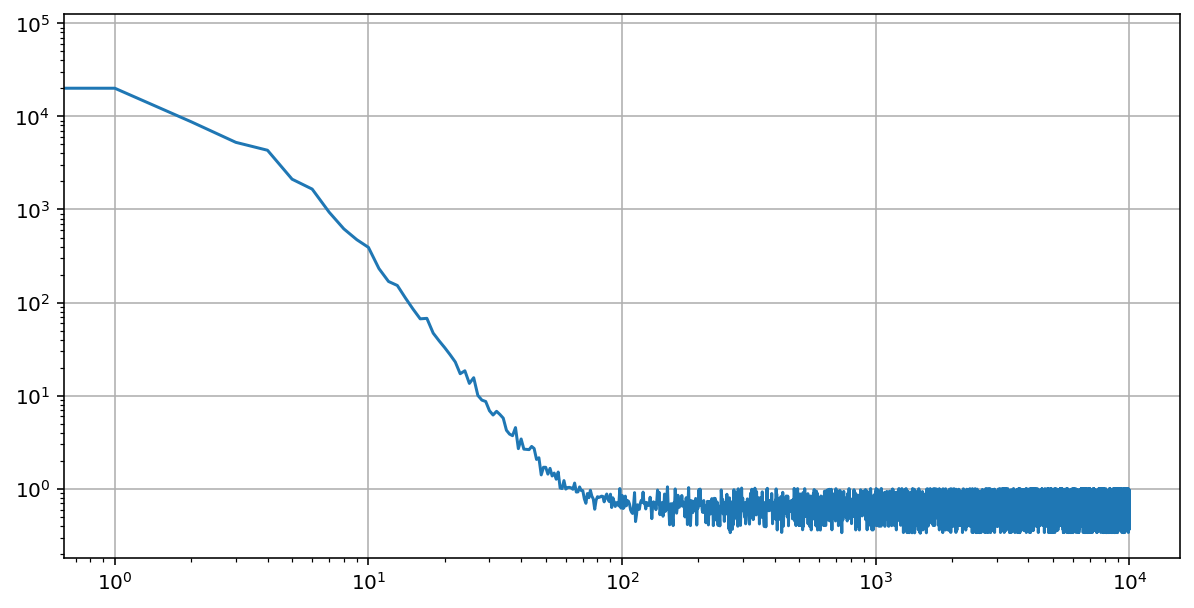

In [689]:
weights_initial = np.random.rand(1, X_train.shape[1]).T
loss_hist, y_bar = accelegrad_v2(weights_initial,
                              X_train,
                              y_train,
                              D=100,
                              G=0,
                              lamb=10,
                              max_iter=10000)

plt.plot(loss_hist)
plt.grid()
plt.yscale('log')
plt.xscale('log')

[1.e-05 1.e-04 1.e-03 1.e-02 1.e-01 1.e+00 1.e+01 1.e+02 1.e+03 1.e+04
 1.e+05 1.e+06]


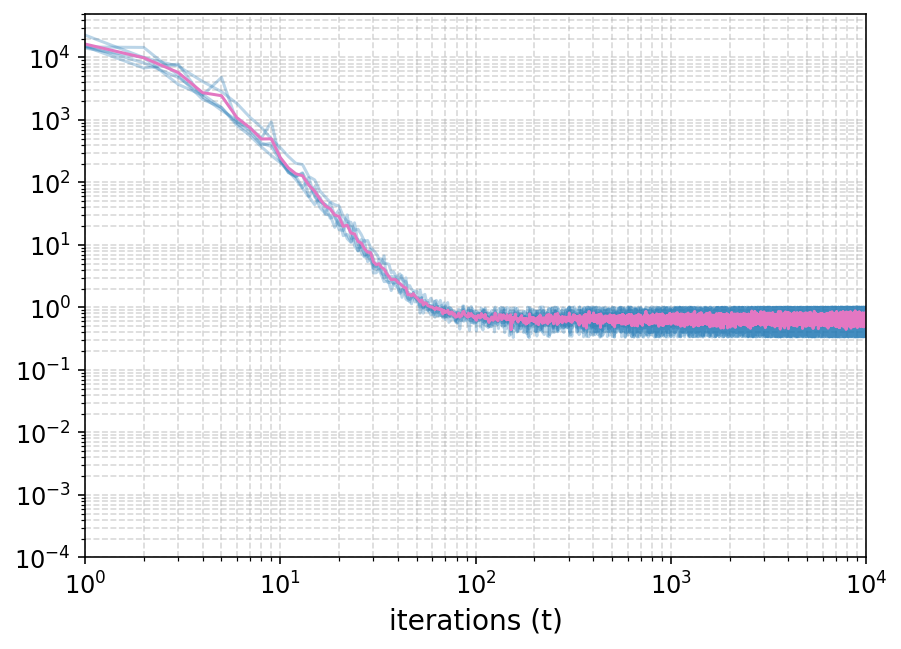

In [748]:
max_iter = 10000

plt.figure(figsize=(7,5))
plt.yscale('log')
plt.xscale('log')
plt.grid(which='both', ls="--", alpha=0.5)

losses = []
for i in range(5):
    weights_initial = np.random.rand(1,X_train.shape[1]).T
    #weights_initial = np.zeros((X_train.shape[1],1))
    loss, y_bar = accelegrad_v2(weights_initial,
                             X_train,
                             y_train,
                             D=1e2,
                             G=0,
                             lamb=10,
                             max_iter=max_iter)
    
    plt.plot(loss, alpha=0.3, c='tab:blue')
    
    losses.append(loss)

mean_loss = np.mean(losses,axis=0)
plt.plot(mean_loss, c='tab:pink')
plt.xlabel(r"iterations (t)", fontsize=14)
plt.xlim([1,max_iter])
plt.ylim([1e-4,5*1e4])
locs, labels = plt.yticks()
print(locs)
prin
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.show()

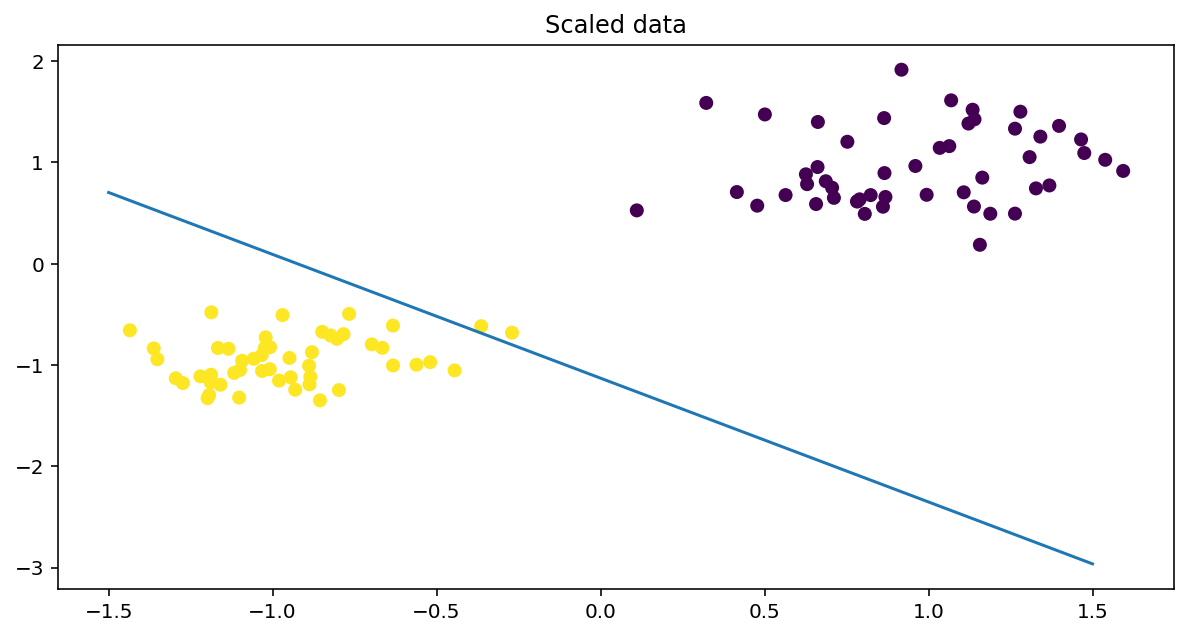

In [736]:
x_ax = np.arange(-1.5,1.6,0.1)
f = -(b[0]/b[2]) - (b[1]/b[2])*x_ax
plt.scatter(data[:,1],data[:,2], c=labels)
plt.plot(x_ax, f)
plt.title("Scaled data")
plt.show()